# Data Quality & Operational Analysis
**Data Source:** JABookings and JAReleases CSV logs (Dec 2025 - Jan 2026).

This notebook evaluates the quality of the jail log data and provides operational insights into court workloads and attorney representation.

**Key Questions:**
1.  **Data Gaps:** Which fields are frequently missing?
2.  **Representation:** What % of bookings have an attorney listed?
3.  **Court Load:** Which courts are processing the most cases?
4.  **Release Operations:** When do releases occur?

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading
Loading Bookings and Releases.

In [2]:
booking_files = sorted(glob.glob("JABookings_*.csv"))
release_files = sorted(glob.glob("JAReleases_*.csv"))

# Load Bookings
b_dfs = []
for f in booking_files:
    try:
        b_dfs.append(pd.read_csv(f))
    except:
        pass
bookings = pd.concat(b_dfs, ignore_index=True) if b_dfs else pd.DataFrame()

# Load Releases
r_dfs = []
for f in release_files:
    try:
        r_dfs.append(pd.read_csv(f))
    except:
        pass
releases = pd.concat(r_dfs, ignore_index=True) if r_dfs else pd.DataFrame()

# Deduplicate
if not bookings.empty:
    bookings = bookings.drop_duplicates(subset=['SONumber', 'CaseNumber', 'ConfineDate'])
if not releases.empty:
    releases = releases.drop_duplicates(subset=['SONumber', 'CaseNumber', 'ReleaseDate'])

print(f"Bookings: {len(bookings)}")
print(f"Releases: {len(releases)}")

Bookings: 5824
Releases: 5034


## 2. Missing Data Analysis
Visualizing null values.

Missing Data Percentage (Bookings):
BondType        50.738324
BondAmount      50.686813
AttorneyName    39.182692
CaseNumber      12.551511
Court           12.551511
Address1         5.700549
dtype: float64


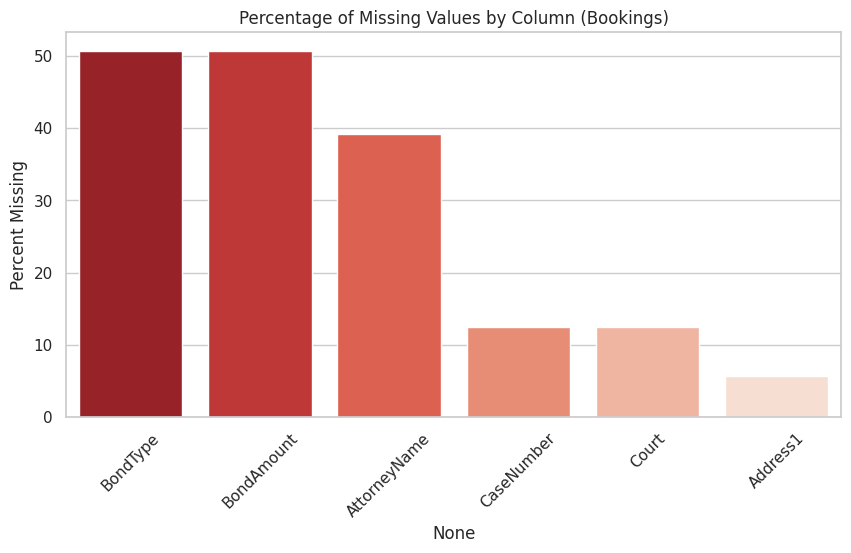

In [3]:
if not bookings.empty:
    missing_pct = bookings.isnull().mean() * 100
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
    
    print("Missing Data Percentage (Bookings):")
    print(missing_pct)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_pct.index, y=missing_pct.values, hue=missing_pct.index, legend=False, palette='Reds_r')
    plt.title('Percentage of Missing Values by Column (Bookings)')
    plt.ylabel('Percent Missing')
    plt.xticks(rotation=45)
    plt.show()

## 3. Attorney Representation
Who is being represented?

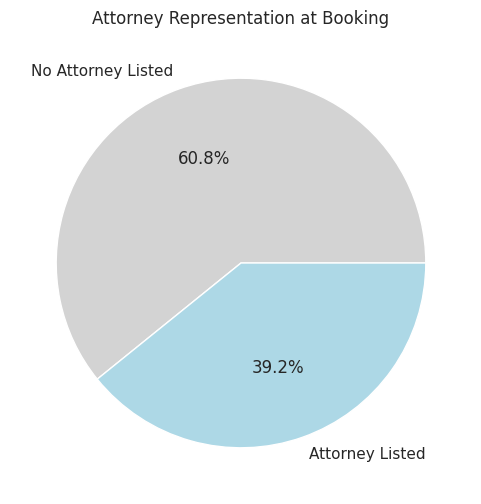

In [4]:
has_attorney = bookings['AttorneyName'].notna().value_counts()

plt.figure(figsize=(6, 6))
plt.pie(has_attorney, labels=['No Attorney Listed', 'Attorney Listed'], autopct='%1.1f%%', colors=['lightgray', 'lightblue'])
plt.title('Attorney Representation at Booking')
plt.show()

if 'Attorney Listed' in has_attorney.index:
    top_attorneys = bookings['AttorneyName'].value_counts().head(10)
    print()
    print("Top 10 Attorneys:")
    print(top_attorneys)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_attorneys.index, x=top_attorneys.values, hue=top_attorneys.index, legend=False, palette='viridis')
    plt.title('Top 10 Attorneys by Case Volume')
    plt.xlabel('Cases')
    plt.show()

## 4. Court Workload
Distribution of cases across courts.

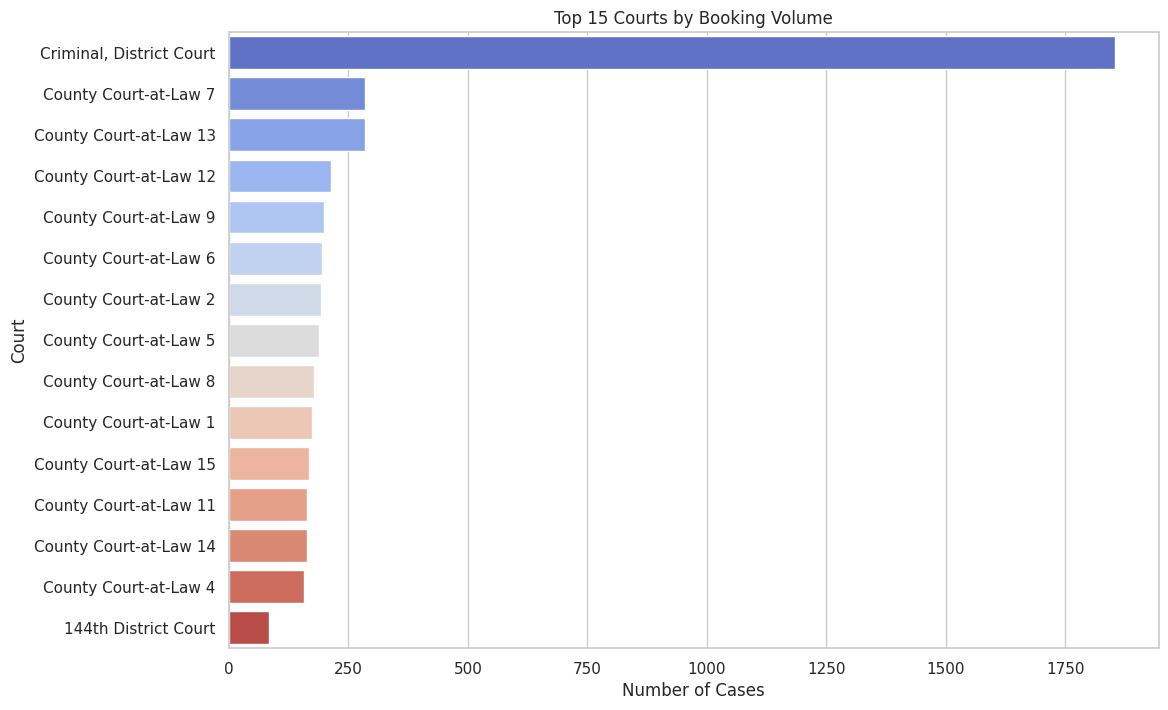

In [5]:
top_courts = bookings['Court'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_courts.index, x=top_courts.values, hue=top_courts.index, legend=False, palette='coolwarm')
plt.title('Top 15 Courts by Booking Volume')
plt.xlabel('Number of Cases')
plt.show()

## 5. Release Timing
When are people released?

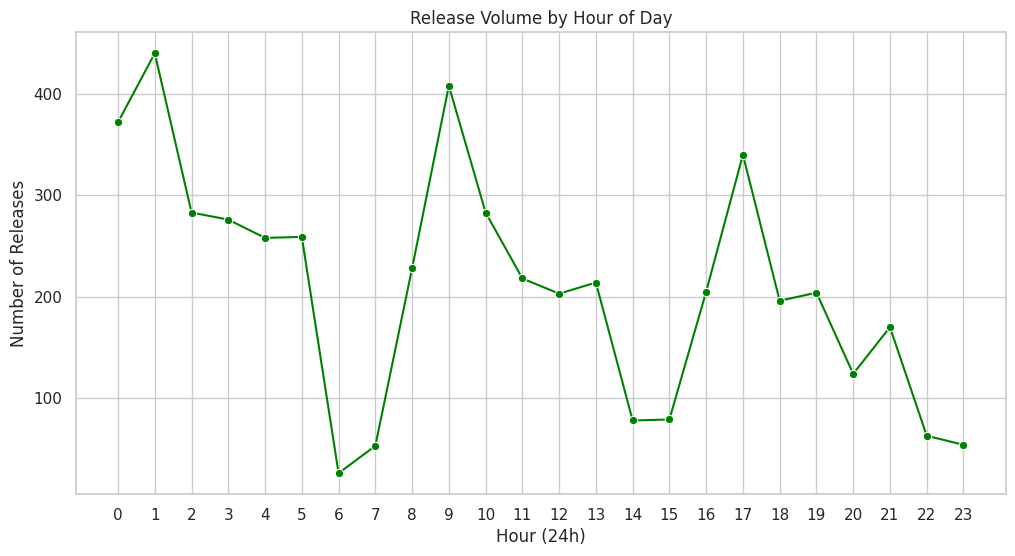

In [6]:
if 'ReleaseTime' in releases.columns:
    # Convert to datetime to extract hour. Format is typically like '11:10 PM'
    releases['ReleaseHour'] = pd.to_datetime(releases['ReleaseTime'], format='%I:%M %p', errors='coerce').dt.hour
    
    hourly_counts = releases['ReleaseHour'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', color='green')
    plt.title('Release Volume by Hour of Day')
    plt.xlabel('Hour (24h)')
    plt.ylabel('Number of Releases')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()
else:
    print("ReleaseTime column not found.")